In [1]:
# ============================================================================
# 1. IMPORTS & SETUP
# ============================================================================
import os
import random
import json
import warnings
from pathlib import Path
from typing import Tuple, Optional
import csv
import json


import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# Metrics (medpy)
try:
    from medpy.metric.binary import hd95 as medpy_hd95, assd as medpy_assd
except Exception as e:
    medpy_hd95 = None
    medpy_assd = None
    print("Warning: medpy not available. Install it with `pip install medpy` to compute HD95/ASSD.")

warnings.filterwarnings('ignore')

# Paths
DATA_ROOT = Path(r'../../data/processed/2d/labeled')
CONFIG_DIR = Path(r'../../configs/splits_2d')

LOG_DIR = Path(r'D:/Project Advanced CV/logs/unetpp_2d')
CKPT_DIR = Path(r'D:/Project Advanced CV/checkpoints/unetpp_2d')

LOG_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Seed
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"✓ Seed set to {seed}")

set_seed(42)


✓ Seed set to 42


In [2]:
# ============================================================================
# 2. LOGGER
# ============================================================================
import logging

def setup_logger(log_dir: Path, name: str = 'unetpp_2d') -> logging.Logger:
    log_file = log_dir / 'training_log.txt'
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    logger.handlers.clear()
    fh = logging.FileHandler(log_file, encoding='utf-8')
    fh.setLevel(logging.INFO)
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    formatter = logging.Formatter('[%(levelname)s] %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    logger.addHandler(fh)
    logger.addHandler(ch)
    logger.info(f'Logger initialized. Log file: {log_file}')
    return logger

logger = setup_logger(LOG_DIR)


[INFO] Logger initialized. Log file: D:\Project Advanced CV\logs\unetpp_2d\training_log.txt


## CELL 3 — DATASET & DATALOADER (with resize)

In [3]:
# ============================================================================
# 3. DATASET & DATALOADER
# ============================================================================
class Brats2dDataset(Dataset):
    def __init__(self, data_root, split_file, resize_to: Tuple[int,int]=(128,128)):
        self.data_root = Path(data_root)
        self.resize_to = resize_to
        # read split file (one case per line like: something_Brain_001)
        with open(split_file, 'r') as f:
            case_names = [ln.strip() for ln in f if ln.strip()]
        target_dirs = {f'Brain_{name.split("_")[-1]}' for name in case_names if name}
        self.samples = []
        for case_dir in sorted(self.data_root.iterdir()):
            if not case_dir.is_dir(): 
                continue
            if case_dir.name not in target_dirs:
                continue
            mask_dir = case_dir / 'mask'
            if not mask_dir.exists():
                continue
            for mask_file in sorted(mask_dir.glob('*.png')):
                sid = mask_file.stem.split('_')[-1]
                paths = {
                    'flair': case_dir/'flair'/f'flair_{sid}.png',
                    't1':    case_dir/'t1'/f't1_{sid}.png',
                    't1ce':  case_dir/'t1ce'/f't1ce_{sid}.png',
                    't2':    case_dir/'t2'/f't2_{sid}.png',
                    'mask':  mask_file
                }
                if all(p.exists() for p in paths.values()):
                    self.samples.append(paths)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        chans = []
        for mod in ['flair','t1','t1ce','t2']:
            im = Image.open(sample[mod]).convert('L')
            if self.resize_to:
                im = im.resize(self.resize_to, Image.BILINEAR)
            arr = np.array(im, dtype=np.float32) / 255.0
            chans.append(arr)
        image = np.stack(chans, axis=0)  # (C,H,W)
        image = torch.from_numpy(image).float()
        mask = Image.open(sample['mask'])
        if self.resize_to:
            mask = mask.resize(self.resize_to, Image.NEAREST)
        mask = torch.from_numpy(np.array(mask, dtype=np.int64)).long()
        return image, mask


def get_dataloaders(data_root: Path, config_dir: Path, batch_size: int = 8, resize_to: Tuple[int,int]=(128,128), num_workers: int = 4):
    train_file = config_dir / 'train.txt'
    val_file = config_dir / 'val.txt'
    train_ds = Brats2dDataset(data_root, train_file, resize_to)
    val_ds   = Brats2dDataset(data_root, val_file, resize_to)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    logger.info(f'Train samples: {len(train_ds)}, Val samples: {len(val_ds)}')
    return train_loader, val_loader


## CELL 4 — UNet++ (full)

In [4]:
# ============================================================================
# 4. UNet++ (full)
# ============================================================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=4, num_classes=4, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        nb_filter = [32, 64, 128, 256, 512]

        # Encoder
        self.conv0_0 = ConvBlock(in_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])

        # Decoder level 1
        self.conv0_1 = ConvBlock(nb_filter[0] + nb_filter[1], nb_filter[0])
        self.conv1_1 = ConvBlock(nb_filter[1] + nb_filter[2], nb_filter[1])
        self.conv2_1 = ConvBlock(nb_filter[2] + nb_filter[3], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3] + nb_filter[4], nb_filter[3])

        # Decoder level 2
        self.conv0_2 = ConvBlock(nb_filter[0]*2 + nb_filter[1], nb_filter[0])
        self.conv1_2 = ConvBlock(nb_filter[1]*2 + nb_filter[2], nb_filter[1])
        self.conv2_2 = ConvBlock(nb_filter[2]*2 + nb_filter[3], nb_filter[2])

        # Decoder level 3
        self.conv0_3 = ConvBlock(nb_filter[0]*3 + nb_filter[1], nb_filter[0])
        self.conv1_3 = ConvBlock(nb_filter[1]*3 + nb_filter[2], nb_filter[1])

        # Decoder level 4
        self.conv0_4 = ConvBlock(nb_filter[0]*4 + nb_filter[1], nb_filter[0])

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Decoder level 1
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], dim=1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], dim=1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], dim=1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], dim=1))

        # Decoder level 2
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], dim=1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], dim=1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], dim=1))

        # Decoder level 3
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], dim=1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], dim=1))

        # Decoder level 4
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], dim=1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            return self.final(x0_4)


## CELL 5 — LOSSES (Dice + Combined with component return)

In [5]:
# ============================================================================
# 5. LOSSES
# ============================================================================
class DiceLossFull(nn.Module):
    def __init__(self, smooth=1e-6, ignore_index=None):
        super().__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index

    def forward(self, logits, target):
        # logits: (B,C,H,W), target: (B,H,W)
        probs = F.softmax(logits, dim=1)
        num_classes = probs.shape[1]
        target_onehot = F.one_hot(target, num_classes).permute(0,3,1,2).float()

        dices = []
        for c in range(num_classes):
            if c == self.ignore_index:
                continue
            p = probs[:, c]
            t = target_onehot[:, c]
            inter = (p * t).sum()
            union = p.sum() + t.sum()
            dice_c = (2.0 * inter + self.smooth) / (union + self.smooth)
            dices.append(dice_c)
        if len(dices) == 0:
            return torch.tensor(0.0, device=logits.device)
        return 1.0 - torch.stack(dices).mean()

class CombinedLossFull(nn.Module):
    def __init__(self, ignore_index=None):
        super().__init__()

        self.dice = DiceLossFull(ignore_index=ignore_index)
        self.ce = nn.CrossEntropyLoss(ignore_index=ignore_index if ignore_index is not None else -100)

    def forward(self, logits, target, return_components: bool = True):
        dice_l = self.dice(logits, target)
        ce_l = self.ce(logits, target)
        
        # TotalLoss = Dice + CE
        total = dice_l + ce_l
        
        if return_components:
            return total, dice_l, ce_l
        return total


## CELL 6 — METRICS (Dice, IoU, ASSD, HD95) — robust

In [6]:
# ============================================================================
# 6. METRICS
# ============================================================================
def dice_metric(logits, target, num_classes=4, ignore_index=None):
    preds = torch.argmax(logits, dim=1)
    per_class = []
    for c in range(num_classes):
        if c == ignore_index:
            continue
        pred_c = (preds == c).float()
        target_c = (target == c).float()
        inter = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        if union.item() == 0:
            per_class.append(1.0)
        else:
            per_class.append(((2.0 * inter + 1e-6) / (union + 1e-6)).item())
    return float(np.mean(per_class))

def iou_metric(logits, target, num_classes=4, ignore_index=None):
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    target_np = target.cpu().numpy()
    per_class = []
    for c in range(num_classes):
        if c == ignore_index:
            continue
        p = (preds == c).astype(np.uint8)
        t = (target_np == c).astype(np.uint8)
        inter = np.logical_and(p, t).sum()
        union = np.logical_or(p, t).sum()
        if union == 0:
            per_class.append(1.0)
        else:
            per_class.append(inter / union)
    return float(np.mean(per_class))

def asd_metric(logits, target, num_classes=4, ignore_index=None):
    if medpy_assd is None:
        return float('nan')
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    target_np = target.cpu().numpy()
    vals = []
    for c in range(num_classes):
        if c == ignore_index:
            continue
        p = (preds == c).astype(np.uint8)
        t = (target_np == c).astype(np.uint8)
        if p.sum() == 0 and t.sum() == 0:
            vals.append(0.0)
            continue
        try:
            v = medpy_assd(p, t)
            vals.append(float(v))
        except Exception:
            vals.append(float('inf'))
    return float(np.mean(vals))

def hd95_metric(logits, target, num_classes=4, ignore_index=None):
    if medpy_hd95 is None:
        return float('nan')
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    target_np = target.cpu().numpy()
    vals = []
    for c in range(num_classes):
        if c == ignore_index:
            continue
        p = (preds == c).astype(np.uint8)
        t = (target_np == c).astype(np.uint8)
        if p.sum() == 0 and t.sum() == 0:
            vals.append(0.0)
            continue
        try:
            v = medpy_hd95(p, t)
            vals.append(float(v))
        except Exception:
            vals.append(float('inf'))
    return float(np.mean(vals))


## CELL 7 — SAVE / LOAD CHECKPOINT

In [7]:
# ============================================================================
# 7. CHECKPOINT HELPERS
# ============================================================================
def save_checkpoint(state: dict, path: Path):
    torch.save(state, str(path))
    logger.info(f"Saved checkpoint: {path}")

def load_checkpoint(path: Path, device=None):
    ckpt = torch.load(str(path), map_location=device)
    logger.info(f"Loaded checkpoint: {path}")
    return ckpt


## CELL 8 — TRAIN / VALIDATE (with per-epoch logging of total/dice/ce and metrics)

In [8]:
# ============================================================================
# 8. TRAIN / VALIDATE
# ============================================================================
def train_epoch(model, loader, optimizer, criterion: CombinedLossFull, device):
    model.train()
    running_total = 0.0
    running_dice = 0.0
    running_ce = 0.0
    n_batches = 0

    pbar = tqdm(loader, desc="Train", leave=False)
    for images, masks in pbar:
        images = images.to(device)
        masks  = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # (B,C,H,W)
        total, dice_l, ce_l = criterion(outputs, masks, return_components=True)
        total.backward()
        optimizer.step()

        running_total += float(total.item())
        running_dice += float(dice_l.item())
        running_ce += float(ce_l.item())
        n_batches += 1

        pbar.set_postfix({'tot': f'{running_total/n_batches:.4f}',
                          'dice': f'{running_dice/n_batches:.4f}',
                          'ce': f'{running_ce/n_batches:.4f}'})
    return running_total / n_batches, running_dice / n_batches, running_ce / n_batches

@torch.no_grad()
def validate_epoch(model, loader, criterion: CombinedLossFull, device):
    model.eval()
    running_total = 0.0
    running_dice = 0.0
    running_ce = 0.0

    all_dice, all_iou, all_asd, all_hd = 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    n_samples = 0

    pbar = tqdm(loader, desc="Val", leave=False)
    for images, masks in pbar:
        images = images.to(device)
        masks  = masks.to(device)
        outputs = model(images)
        total, dice_l, ce_l = criterion(outputs, masks, return_components=True)

        batch_size = images.size(0)
        running_total += float(total.item())
        running_dice += float(dice_l.item())
        running_ce += float(ce_l.item())

        # metrics (per-batch averaged)
        d = dice_metric(outputs, masks)
        i = iou_metric(outputs, masks)
        a = asd_metric(outputs, masks)
        h = hd95_metric(outputs, masks)

        all_dice += d * batch_size
        all_iou  += i * batch_size
        all_asd  += (0.0 if np.isnan(a) else a) * batch_size
        all_hd   += (0.0 if np.isnan(h) else h) * batch_size

        n_batches += 1
        n_samples += batch_size

    if n_batches == 0:
        return {}, 0

    avg_total = running_total / n_batches
    avg_dice_l = running_dice / n_batches
    avg_ce_l = running_ce / n_batches

    avg_dice = all_dice / n_samples
    avg_iou  = all_iou / n_samples
    avg_asd  = all_asd / n_samples
    avg_hd   = all_hd / n_samples

    metrics = {
        'val_total_loss': avg_total,
        'val_dice_loss': avg_dice_l,
        'val_ce_loss': avg_ce_l,
        'dice': float(avg_dice),
        'iou': float(avg_iou),
        'asd': float(avg_asd),
        'hd95': float(avg_hd)
    }
    return metrics


## CELL 9 — TRAINING LOOP / ENTRYPOINT

In [9]:
# ============================================================================
# 9. TRAINING LOOP / ENTRYPOINT
# ============================================================================
def train_model_main(
    data_root: Path,
    config_dir: Path,
    ckpt_dir: Path,
    log_dir: Path,
    num_epochs: int = 10,
    batch_size: int = 8,
    lr: float = 1e-4,
    resize_to: Tuple[int,int] = (128,128),
    num_workers: int = 4,
    resume_from: Optional[Path] = None,
    device: Optional[torch.device] = None
):
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    logger.info(f'Using device: {device}')

    train_loader, val_loader = get_dataloaders(data_root, config_dir, batch_size, resize_to, num_workers)

    model = UNetPlusPlus(in_channels=4, num_classes=4, deep_supervision=False).to(device)
    criterion = CombinedLossFull()
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    start_epoch = 0
    best_dice = -1.0

    # --- CSV file setup ---
    import csv
    csv_file = log_dir / "metrics_log.csv"
    if not csv_file.exists():
        with open(csv_file, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                "epoch",
                "train_total_loss", "train_dice_loss", "train_ce_loss",
                "val_total_loss", "val_dice_loss", "val_ce_loss",
                "val_dice", "val_iou", "val_asd", "val_hd95"
            ])


    # --- JSON file setup ---
    import json
    json_file = log_dir / "metrics_log.json"
    if not json_file.exists():
        with open(json_file, 'w') as f:
            json.dump([], f, indent=2)


    if resume_from:
        if Path(resume_from).exists():
            ck = load_checkpoint(Path(resume_from), device)
            model.load_state_dict(ck['model'])
            optimizer.load_state_dict(ck['optimizer'])
            if 'scheduler' in ck:
                scheduler.load_state_dict(ck['scheduler'])
            start_epoch = ck.get('epoch', 0) + 1
            best_dice = ck.get('best_dice', best_dice)
            logger.info(f"Resumed from {resume_from} at epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        logger.info(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
        tot_l, dice_l, ce_l = train_epoch(model, train_loader, optimizer, criterion, device)
        logger.info(f"[TRAIN] TotalLoss={tot_l:.4f} | DiceLoss={dice_l:.4f} | CELoss={ce_l:.4f}")

        metrics = validate_epoch(model, val_loader, criterion, device)
        if metrics:
            logger.info(f"[VAL] TotalLoss={metrics['val_total_loss']:.4f} | DiceLoss={metrics['val_dice_loss']:.4f} | CELoss={metrics['val_ce_loss']:.4f}")
            logger.info(f"[METRICS] Dice={metrics['dice']:.4f} | IoU={metrics['iou']:.4f} | ASD={metrics['asd']:.4f} | HD95={metrics['hd95']:.4f}")
            
        # --- Save metrics to CSV ---
        with open(csv_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch+1,
                tot_l, dice_l, ce_l,
                metrics.get('val_total_loss', 0),
                metrics.get('val_dice_loss', 0),
                metrics.get('val_ce_loss', 0),
                metrics.get('dice', 0),
                metrics.get('iou', 0),
                metrics.get('asd', 0),
                metrics.get('hd95', 0)
            ])

        # --- Save metrics to JSON ---
        epoch_data = {
            "epoch": epoch + 1,
            "train_total_loss": tot_l,
            "train_dice_loss": dice_l,
            "train_ce_loss": ce_l,
            "val_total_loss": metrics.get('val_total_loss', 0),
            "val_dice_loss": metrics.get('val_dice_loss', 0),
            "val_ce_loss": metrics.get('val_ce_loss', 0),
            "val_dice": metrics.get('dice', 0),
            "val_iou": metrics.get('iou', 0),
            "val_asd": metrics.get('asd', 0),
            "val_hd95": metrics.get('hd95', 0)
        }
        with open(json_file, 'r+') as f:
            data = json.load(f)
            data.append(epoch_data)
            f.seek(0)
            json.dump(data, f, indent=2)


        
        # --- Update best Dice ---
        if metrics['dice'] > best_dice:
            best_dice = metrics['dice']
            best_ckpt_path = Path(ckpt_dir) / "best_checkpoint.pth"
            state_best = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'best_dice': best_dice,
                'metrics': metrics
            }
            save_checkpoint(state_best, best_ckpt_path)
            logger.info(f"New best Dice: {best_dice:.4f}, saved to {best_ckpt_path}")
        
        
        # scheduler step
        scheduler.step()

        # save checkpoint
        ckpt_path = Path(ckpt_dir) / f"checkpoint_epoch_{epoch+1:03d}.pth"
        state = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_dice': best_dice,
            'metrics': metrics
        }
        save_checkpoint(state, ckpt_path)


## CELL 10 — CONFIG & RUN

In [30]:
# ============================================================================
# 10. CONFIG & RUN
# ============================================================================
CONFIG = {
    'data_root': DATA_ROOT,
    'config_dir': CONFIG_DIR,
    'ckpt_dir': CKPT_DIR,
    'log_dir': LOG_DIR,
    'num_epochs': 30,
    'batch_size': 8,
    'learning_rate': 1e-3,
    'resize_to': (128,128),
    'num_workers': 0,
    'resume_from': None
}

logger.info("Training Configuration:")
logger.info(json.dumps({k: str(v) if isinstance(v, Path) else v for k,v in CONFIG.items()}, indent=2))

train_model_main(
    data_root=CONFIG['data_root'],
    config_dir=CONFIG['config_dir'],
    ckpt_dir=CONFIG['ckpt_dir'],
    log_dir=CONFIG['log_dir'],
    num_epochs=CONFIG['num_epochs'],
    batch_size=CONFIG['batch_size'],
    lr=CONFIG['learning_rate'],
    resize_to=CONFIG['resize_to'],
    num_workers=CONFIG['num_workers'],
    resume_from=CONFIG['resume_from']
)


[INFO] Training Configuration:
[INFO] {
  "data_root": "..\\..\\data\\processed\\2d\\labeled",
  "config_dir": "..\\..\\configs\\splits_2d",
  "ckpt_dir": "D:\\Project Advanced CV\\checkpoints\\unetpp_2d",
  "log_dir": "D:\\Project Advanced CV\\logs\\unetpp_2d",
  "num_epochs": 30,
  "batch_size": 8,
  "learning_rate": 0.001,
  "resize_to": [
    128,
    128
  ],
  "num_workers": 0,
  "resume_from": null
}
[INFO] Using device: cuda


KeyboardInterrupt: 

## INFERENCE VÀ ĐÁNH GIÁ 3D CHI TIẾT (WT, TC, ET) TRÊN TẬP TEST

In [46]:
# ============================================================================
# 11. INFERENCE & ĐÁNH GIÁ 3D CHI TIẾT - FULL PIPELINE
# ============================================================================
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from typing import Tuple
from tqdm import tqdm
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

# Metrics từ medpy
try:
    from medpy.metric.binary import hd95 as medpy_hd95, assd as medpy_assd
except ImportError:
    medpy_hd95, medpy_assd = None, None

# Logger đơn giản
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ============================================================================
# 1. Dataset cho tập Test
# ============================================================================
class Brats2dTestDataset(Dataset):
    def __init__(self, data_root, split_file, resize_to: Tuple[int,int]=(128,128)):
        self.data_root = Path(data_root)
        self.resize_to = resize_to  # resize input cho mạng
        with open(split_file, 'r') as f:
            case_names = [ln.strip() for ln in f if ln.strip()]
        
        target_dirs = {f'Brain_{name.split("_")[-1]}' for name in case_names if name}
        self.samples = []
        
        for case_dir in sorted(self.data_root.iterdir()):
            if not case_dir.is_dir() or case_dir.name not in target_dirs:
                continue
            
            mask_dir = case_dir / 'mask'
            if not mask_dir.exists():
                continue
                
            for mask_file in sorted(mask_dir.glob('*.png')):
                sid = mask_file.stem.split('_')[-1]
                paths = {
                    'flair': case_dir/'flair'/f'flair_{sid}.png',
                    't1':    case_dir/'t1'/f't1_{sid}.png',
                    't1ce':  case_dir/'t1ce'/f't1ce_{sid}.png',
                    't2':    case_dir/'t2'/f't2_{sid}.png',
                    'mask':  mask_file
                }
                if all(p.exists() for p in paths.values()):
                    self.samples.append({'paths': paths, 'patient_id': case_dir.name})

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        paths = sample['paths']
        patient_id = sample['patient_id']

        chans = []
        for mod in ['flair','t1','t1ce','t2']:
            im = Image.open(paths[mod]).convert('L')
            if self.resize_to:  # resize input về 128x128
                im = im.resize(self.resize_to, Image.BILINEAR)
            arr = np.array(im, dtype=np.float32) / 255.0
            chans.append(arr)
        image = np.stack(chans, axis=0)
        image = torch.from_numpy(image).float()

        mask = Image.open(paths['mask'])
        mask = torch.from_numpy(np.array(mask, dtype=np.int64)).long()
        
        return image, mask, patient_id

# ============================================================================
# 2. Metric 3D helper
# ============================================================================
def _compute_single_region_metrics(pred_mask: np.ndarray, true_mask: np.ndarray) -> dict:
    metrics = {}
    
    # Dice & IoU
    intersection = np.logical_and(pred_mask, true_mask).sum()
    pred_sum = pred_mask.sum()
    true_sum = true_mask.sum()

    if pred_sum + true_sum == 0:
        metrics['dice'] = 1.0
        metrics['iou'] = 1.0
    else:
        metrics['dice'] = (2.*intersection)/(pred_sum+true_sum) if (pred_sum+true_sum)>0 else 0.0
        iou_den = pred_sum + true_sum - intersection
        metrics['iou'] = intersection/iou_den if iou_den>0 else 0.0
    
    # ASD & HD95
    if medpy_assd is None or medpy_hd95 is None:
        metrics['asd'] = float('nan')
        metrics['hd95'] = float('nan')
    else:
        if not np.any(pred_mask) and not np.any(true_mask):
            metrics['asd'] = 0.0
            metrics['hd95'] = 0.0
        elif not np.any(pred_mask) or not np.any(true_mask):
            metrics['asd'] = float('inf')
            metrics['hd95'] = float('inf')
        else:
            try:
                metrics['asd'] = medpy_assd(pred_mask.astype(np.uint8), true_mask.astype(np.uint8))
                metrics['hd95'] = medpy_hd95(pred_mask.astype(np.uint8), true_mask.astype(np.uint8))
            except Exception:
                metrics['asd'] = float('inf')
                metrics['hd95'] = float('inf')
    return metrics

def calculate_3d_metrics_for_patient(pred_vol: np.ndarray, true_vol: np.ndarray) -> dict:
    # Masks cho WT, TC, ET
    pred_wt = np.isin(pred_vol, [1,2,3])
    true_wt = np.isin(true_vol, [1,2,3])
    
    pred_tc = np.isin(pred_vol, [1,3])
    true_tc = np.isin(true_vol, [1,3])
    
    pred_et = (pred_vol==3)
    true_et = (true_vol==3)
    
    metrics_wt = _compute_single_region_metrics(pred_wt, true_wt)
    metrics_tc = _compute_single_region_metrics(pred_tc, true_tc)
    metrics_et = _compute_single_region_metrics(pred_et, true_et)
    
    final_metrics = {}
    for k in metrics_wt.keys():
        final_metrics[f'{k}_wt'] = metrics_wt[k]
        final_metrics[f'{k}_tc'] = metrics_tc[k]
        final_metrics[f'{k}_et'] = metrics_et[k]
    return final_metrics

# ============================================================================
# 3. Evaluate function
# ============================================================================
@torch.no_grad()
def evaluate_on_test_set(
    model, 
    data_root: Path, 
    config_dir: Path, 
    batch_size: int = 8, 
    resize_input: Tuple[int,int] = (128,128),  # resize input cho mạng
    resize_metric: Tuple[int,int] = (194,194),  # resize prediction + mask trước tính metric
    device: torch.device = torch.device('cpu')
):
    model.to(device)
    model.eval()

    test_file = config_dir / 'test.txt'
    test_ds = Brats2dTestDataset(data_root, test_file, resize_input)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    
    logger.info(f"Bắt đầu inference trên {len(test_ds.samples)} lát cắt từ tập test...")

    preds_by_patient = defaultdict(list)
    masks_by_patient = defaultdict(list)
    
    pbar = tqdm(test_loader, desc="Inference trên các lát cắt 2D")
    for images, masks, patient_ids in pbar:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        for i in range(len(patient_ids)):
            patient_id = patient_ids[i]
            # Resize output + mask về 194x194 trước tính metric
            pred_resized = cv2.resize(preds[i].astype(np.uint8), resize_metric, interpolation=cv2.INTER_NEAREST)
            mask_resized = cv2.resize(masks[i].numpy().astype(np.uint8), resize_metric, interpolation=cv2.INTER_NEAREST)
            
            preds_by_patient[patient_id].append(pred_resized)
            masks_by_patient[patient_id].append(mask_resized)

    logger.info("Hoàn thành inference. Đang xếp chồng các lát cắt và tính toán metric 3D...")
    
    results = []
    patient_ids = sorted(preds_by_patient.keys())
    
    for patient_id in tqdm(patient_ids, desc="Đánh giá trên từng khối 3D"):
        pred_slices = preds_by_patient[patient_id]
        mask_slices = masks_by_patient[patient_id]
        
        pred_volume = np.stack(pred_slices, axis=0)
        mask_volume = np.stack(mask_slices, axis=0)

        patient_metrics = calculate_3d_metrics_for_patient(pred_volume, mask_volume)
        patient_metrics['patient_id'] = patient_id
        results.append(patient_metrics)

    return pd.DataFrame(results)

# ============================================================================
# 4. Chạy toàn bộ pipeline
# ============================================================================
INFERENCE_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BEST_CKPT_PATH = CKPT_DIR / "best_checkpoint.pth"

logger.info(f"Đang tải model từ: {BEST_CKPT_PATH}")
model = UNetPlusPlus(in_channels=4, num_classes=4, deep_supervision=False)
checkpoint = torch.load(BEST_CKPT_PATH, map_location=INFERENCE_DEVICE)
model.load_state_dict(checkpoint['model'])

results_df = evaluate_on_test_set(
    model=model,
    data_root=DATA_ROOT,
    config_dir=CONFIG_DIR,
    batch_size=8,
    resize_input=(128,128),  # resize input trước khi vào mạng
    resize_metric=(194,194), # resize output + mask trước tính metric
    device=INFERENCE_DEVICE
)

# ============================================================================
# 5. Hiển thị và lưu kết quả
# ============================================================================
logger.info("\n--- KẾT QUẢ ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TEST ---")
cols_order = ['patient_id'] + sorted([c for c in results_df.columns if c != 'patient_id'])
results_df = results_df[cols_order]
print(results_df.to_string())

logger.info("\n--- CÁC CHỈ SỐ TRUNG BÌNH TRÊN TẬP TEST ---")
mean_metrics = results_df.replace(np.inf, np.nan).mean(numeric_only=True)
print(mean_metrics)

results_csv_path = LOG_DIR / "test_set_3d_metrics_detailed_ver2.csv"
results_df.to_csv(results_csv_path, index=False, float_format='%.5f')
logger.info(f"Đã lưu kết quả chi tiết vào: {results_csv_path}")


INFO:__main__:Đang tải model từ: D:\Project Advanced CV\checkpoints\unetpp_2d\best_checkpoint.pth


INFO:__main__:Bắt đầu inference trên 8680 lát cắt từ tập test...
Inference trên các lát cắt 2D: 100%|██████████| 1085/1085 [05:06<00:00,  3.54it/s]
INFO:__main__:Hoàn thành inference. Đang xếp chồng các lát cắt và tính toán metric 3D...
Đánh giá trên từng khối 3D: 100%|██████████| 56/56 [06:27<00:00,  6.92s/it]
INFO:__main__:
--- KẾT QUẢ ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TEST ---
INFO:__main__:
--- CÁC CHỈ SỐ TRUNG BÌNH TRÊN TẬP TEST ---
INFO:__main__:Đã lưu kết quả chi tiết vào: D:\Project Advanced CV\logs\unetpp_2d\test_set_3d_metrics_detailed_ver2.csv


   patient_id     asd_et     asd_tc    asd_wt   dice_et   dice_tc   dice_wt    hd95_et    hd95_tc    hd95_wt    iou_et    iou_tc    iou_wt
0   Brain_011   0.923764   0.836440  1.538480  0.736324  0.879024  0.900986   2.236068   2.236068   7.141428  0.582684  0.784160  0.819813
1   Brain_016   1.499660   1.738132  1.100007  0.615142  0.814129  0.897596   3.464102   5.000000   3.000000  0.444192  0.686524  0.814217
2   Brain_023   0.568689   0.601267  0.809855  0.819362  0.929198  0.891681   1.414214   1.414214   2.000000  0.693999  0.867759  0.804535
3   Brain_026   1.531114   1.787894  0.872287  0.630382  0.722788  0.925550   6.403124   5.916080   2.449490  0.460261  0.565911  0.861417
4   Brain_029   0.474892   0.488441  0.672878  0.851451  0.927304  0.917391   1.000000   1.414214   1.414214  0.741328  0.864462  0.847389
5   Brain_037   0.537988   0.746975  1.310999  0.788229  0.917975  0.892224   1.414214   2.000000   3.741657  0.650477  0.848386  0.805419
6   Brain_039   0.573974   

## VISUALIZE INFERENCE

[INFO] Đang tải model từ: D:\Project Advanced CV\checkpoints\unetpp_2d\best_checkpoint.pth để hiển thị.


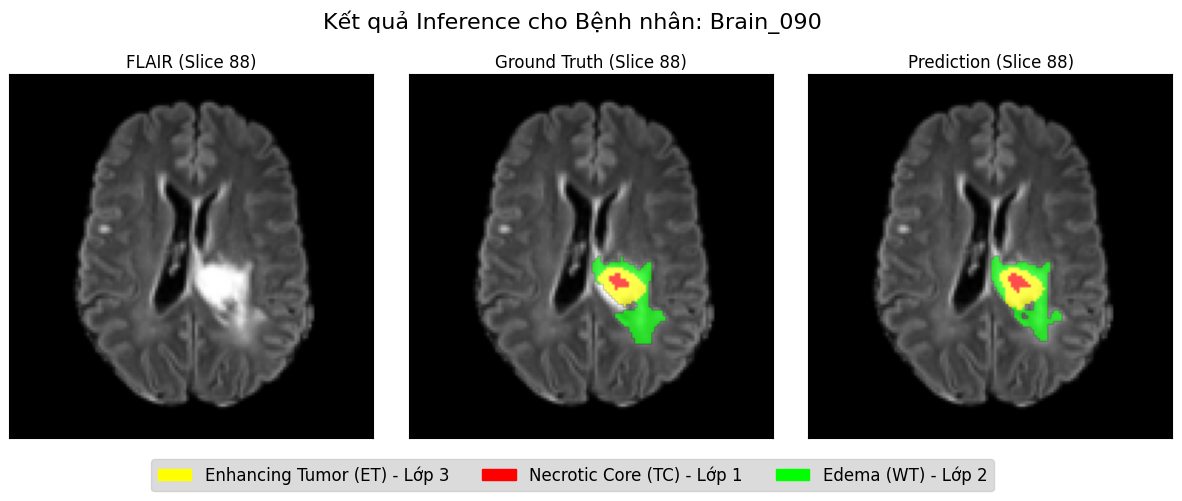

In [30]:
# %% [markdown]
# ## CELL 12 — VISUALIZE INFERENCE (PHIÊN BẢN CUỐI - ĐẢM BẢO NỀN SÁNG)

# %%
# ============================================================================
# 12. VISUALIZE INFERENCE KẾT QUẢ TRÊN NHIỀU LÁT CẮT (ĐẢM BẢO NỀN SÁNG)
# ============================================================================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, Normalize

def visualize_multiple_slices(
    model, 
    data_root: Path,
    patient_id: str,
    slice_indices: list,
    resize_to: Tuple[int,int] = (128,128),
    device: torch.device = torch.device('cpu')
):
    """
    Tải dữ liệu của một bệnh nhân, thực hiện inference trên nhiều lát cắt,
    và hiển thị kết quả trên nền sáng với các khung ngăn cách rõ ràng.
    """
    # Ép buộc sử dụng style mặc định (nền sáng)
    plt.style.use('default')

    model.to(device)
    model.eval()

    # --- 1. Tìm và tải dữ liệu ---
    patient_dir = data_root / patient_id
    if not patient_dir.exists():
        logger.error(f"Thư mục cho bệnh nhân '{patient_id}' không tồn tại tại: {patient_dir}")
        return

    mask_files = sorted(list((patient_dir / 'mask').glob('*.png')), key=lambda p: int(p.stem.split('_')[-1]))
    flair_files = sorted(list((patient_dir / 'flair').glob('*.png')), key=lambda p: int(p.stem.split('_')[-1]))
    
    valid_slice_indices = [idx for idx in slice_indices if 0 <= idx < len(mask_files)]
    if not valid_slice_indices:
        logger.error(f"Không có chỉ số lát cắt nào hợp lệ. Vui lòng chọn trong khoảng 0 đến {len(mask_files) - 1}.")
        return

    num_slices_to_show = len(valid_slice_indices)
    
    # --- 2. Thiết lập lưới hiển thị ---
    fig, axes = plt.subplots(num_slices_to_show, 3, figsize=(15, 5 * num_slices_to_show))
    fig.set_facecolor('white')
    
    if num_slices_to_show == 1:
        axes = axes.reshape(1, -1)

    # --- 3. Vòng lặp qua từng lát cắt ---
    for i, slice_idx in enumerate(valid_slice_indices):
        sid = mask_files[slice_idx].stem.split('_')[-1]
        chans = []
        for mod in ['flair', 't1', 't1ce', 't2']:
            img_path = patient_dir / mod / f'{mod}_{sid}.png'
            im = Image.open(img_path).convert('L').resize(resize_to, Image.BILINEAR)
            chans.append(np.array(im, dtype=np.float32) / 255.0)
        image_tensor = torch.from_numpy(np.stack(chans, axis=0)).float()
        
        flair_img = Image.open(flair_files[slice_idx]).convert('L').resize(resize_to, Image.BILINEAR)
        true_mask = np.array(Image.open(mask_files[slice_idx]).resize(resize_to, Image.NEAREST))

        with torch.no_grad():
            input_tensor = image_tensor.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Hiển thị
        ax_flair, ax_gt, ax_pred = axes[i, 0], axes[i, 1], axes[i, 2]
        
        colors = ['black', '#ff0000', '#00ff00', '#ffff00']
        cmap = ListedColormap(colors)
        norm = Normalize(vmin=0, vmax=len(colors) - 1)

        ax_flair.imshow(flair_img, cmap='gray')
        ax_flair.set_title(f'FLAIR (Slice {slice_idx})', fontsize=12, color='black')
        
        ax_gt.imshow(flair_img, cmap='gray')
        ax_gt.imshow(np.ma.masked_where(true_mask == 0, true_mask), cmap=cmap, norm=norm, alpha=0.7)
        ax_gt.set_title(f'Ground Truth (Slice {slice_idx})', fontsize=12, color='black')
        
        ax_pred.imshow(flair_img, cmap='gray')
        ax_pred.imshow(np.ma.masked_where(pred_mask == 0, pred_mask), cmap=cmap, norm=norm, alpha=0.7)
        ax_pred.set_title(f'Prediction (Slice {slice_idx})', fontsize=12, color='black')
        
        # Thêm khung viền
        for ax in [ax_flair, ax_gt, ax_pred]:
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.5)

    # --- 4. Thêm Legend và Title ---
    legend_patches = [
        mpatches.Patch(color='#ffff00', label='Enhancing Tumor (ET) - Lớp 3'),
        mpatches.Patch(color='#ff0000', label='Necrotic Core (TC) - Lớp 1'),
        mpatches.Patch(color='#00ff00', label='Edema (WT) - Lớp 2'),
    ]

    fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=3, fontsize=12, frameon=True, facecolor='lightgray')
    fig.suptitle(f'Kết quả Inference cho Bệnh nhân: {patient_id}', fontsize=16, y=0.99, color='black')
    
    # Điều chỉnh layout
    fig.subplots_adjust(hspace=0.3, wspace=0.1)
    plt.show()

# ============================================================================
# CẤU HÌNH VÀ CHẠY
# ============================================================================
PATIENT_ID_TO_VISUALIZE = "Brain_090" # Ví dụ
SLICE_INDICES_TO_VISUALIZE = [88] 

# Tải model
inference_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_ckpt_path = CKPT_DIR / "best_checkpoint.pth"

if best_ckpt_path.exists():
    logger.info(f"Đang tải model từ: {best_ckpt_path} để hiển thị.")
    viz_model = UNetPlusPlus(in_channels=4, num_classes=4, deep_supervision=False)
    checkpoint = torch.load(best_ckpt_path, map_location=inference_device)
    viz_model.load_state_dict(checkpoint['model'])

    visualize_multiple_slices(
        model=viz_model,
        data_root=DATA_ROOT,
        patient_id=PATIENT_ID_TO_VISUALIZE,
        slice_indices=SLICE_INDICES_TO_VISUALIZE,
        resize_to=(128,128),   # <-- Sửa lỗi CONFIG tại đây
        device=inference_device
    )
else:
    logger.error(f"Không tìm thấy file checkpoint tại '{best_ckpt_path}'. Vui lòng huấn luyện model trước.")
